In [28]:
import pandas as pd 
import numpy as np
import os
import seaborn
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [3]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_9808\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [4]:
# Show the first few rows of each dataset to understand their structure
print("Raw Sales Data:")
print(raw_sales_df.head())
print("\nMA LGA Data:")
print(ma_lga_df.head())

Raw Sales Data:
    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3

MA LGA Data:
    saledate      MA   type  bedrooms
0 2007-09-30  441854  house         2
1 2007-12-31  441854  house         2
2 2008-03-31  441854  house         2
3 2008-06-30  441854  house         2
4 2008-09-30  451583  house         2


In [5]:
print(raw_sales_df['propertyType'].unique())
print(raw_sales_df['bedrooms'].unique())
print(raw_sales_df['postcode'].unique())

['house' 'unit']
[4 3 5 1 2 0]
[2607 2906 2905 2606 2902 2612 2904 2615 2914 2602 2600 2605 2603 2611
 2903 2617 2913 2604 2614 2912 2601 2900 2620 2618 2616 2911 2609]


In [6]:
# Function to calculate range and unique counts for a single dataframe
# Function to calculate range and unique counts for a single dataframe
def summarize_single_dataframe(df, dataset_name):
    descriptions_raw = {
        'datesold': 'Year in which this property was sold',
        'postcode': '4 digit postcode of the suburb where the property was sold',
        'price': 'Price in AUD for which the property was sold',
        'propertyType': 'Property type i.e. house or unit',
        'bedrooms': 'Number of bedrooms'
    }

    descriptions_ma = {
        'saledate': 'Quarter of the Year',
        'MA': 'Moving Average of Median Price',
        'type': 'Property Type i.e. house or unit',
        'bedrooms': 'Number of bedrooms'
    }

    report = []
    for col in df.columns:
        unique_vals = df[col].dropna().unique()

        if pd.api.types.is_numeric_dtype(df[col]) or pd.api.types.is_datetime64_any_dtype(df[col]):
            if pd.api.types.is_datetime64_any_dtype(df[col]):  # Handle datetime columns
                # Extract the year range for datetime columns
                col_range = [df[col].dt.year.min(), df[col].dt.year.max()]
            else:
                col_range = [df[col].min(), df[col].max()]
        else:
            col_range = sorted(unique_vals) if len(unique_vals) <= 10 else ['Truncated']

        report.append({
            'Variable': col,
            'Description': descriptions_raw.get(col, ''),  # Use the description for the column
            'Range': col_range if len(col_range) > 1 else [col_range[0], col_range[0]],
            'Unique Values Count': len(unique_vals)
        })
    
    # Convert the report to a DataFrame and transpose
    report_df = pd.DataFrame(report).transpose()

    # Format the values to 4 decimal places for float columns (if applicable)
    report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)
    
    # Apply styling
    styled_df = report_df.style.set_properties(**{
        'background-color': 'lightblue',
        'color': 'black',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px'
    })
    
    # Bold the 'Variable' column and header row
    styled_df = styled_df.set_table_styles([{
        'selector': 'th',
        'props': [('font-weight', 'bold'), ('text-align', 'center')]
    },
    {
    'selector': 'tr:nth-child(1)',
    'props': [('font-weight', 'bold')]
    },
    {
        'selector': 'td:nth-child(1)',
        'props': [('font-weight', 'bold')]
    }])
    
    # Add a title centered above the table
    styled_df = styled_df.set_caption(f'<div style="text-align: center; font-size: 18px; font-weight: bold;"> {dataset_name} Summary Report </div>')
    
    return styled_df

# Summarize a single dataframe (use raw_sales_df or ma_lga_df)
styled_report1 = summarize_single_dataframe(raw_sales_df, 'raw_sales_df')
styled_report2 = summarize_single_dataframe(ma_lga_df, 'ma_lga_df')

# Display the styled dataframe (in Jupyter Notebooks or similar environments)
styled_report1



C:\Users\grace\AppData\Local\Temp\ipykernel_9808\699818734.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)
C:\Users\grace\AppData\Local\Temp\ipykernel_9808\699818734.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)


,0,1,2,3,4
Variable,datesold,postcode,price,propertyType,bedrooms
Description,Year in which this property was sold,4 digit postcode of the suburb where the property was sold,Price in AUD for which the property was sold,Property type i.e. house or unit,Number of bedrooms
Range,"[2007, 2019]","[2600, 2914]","[56500, 8000000]","['house', 'unit']","[0, 5]"
Unique Values Count,3582,27,2554,2,6


In [7]:
raw_sales_df

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3
...,...,...,...,...,...
29575,2019-07-25,2900,500000,unit,3
29576,2019-07-25,2612,560000,unit,2
29577,2019-07-26,2912,464950,unit,2
29578,2019-07-26,2601,589000,unit,2


In [8]:
#Preprocessing 'raw_sales_df'

# Convert 'datesold' to datetime and sort by this column
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'], errors='coerce')
raw_sales_df = raw_sales_df.sort_values('datesold')
raw_sales_df.set_index('datesold', inplace=True)

# Handle missing values (if any)
raw_sales_df = raw_sales_df.dropna(subset=['price', 'postcode', 'propertyType', 'bedrooms'])

# Resample the data to monthly frequency - we could aggregate by mean price for each month
monthly_sales = raw_sales_df.resample('M').agg({'price': 'mean'})
monthly_sales['price'] = monthly_sales['price'].round(2)

# Reset index to have 'Date' as a column again
monthly_sales.reset_index(inplace=True)

# Print the resampled data
print(monthly_sales.head())

# Encode categorical variables like 'propertyType' (house/unit)
label_encoder = LabelEncoder()
raw_sales_df['propertyType'] = label_encoder.fit_transform(raw_sales_df['propertyType'])

# One-hot encode postcode as a new feature (optional)
#raw_sales_df = pd.get_dummies(raw_sales_df, columns=['postcode'], drop_first=True)


    datesold      price
0 2007-02-28  407500.00
1 2007-03-31  339333.33
2 2007-04-30  798000.00
3 2007-05-31  339500.00
4 2007-06-30  520333.33


C:\Users\grace\AppData\Local\Temp\ipykernel_9808\2421254435.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = raw_sales_df.resample('M').agg({'price': 'mean'})


In [9]:
#Preprocessing 'ma_lga_df' & cleaning 'ma_lga_12345' DataFrame

# Convert 'saledate' to datetime and sort by this column
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'], errors='coerce')
ma_lga_df = ma_lga_df.sort_values('saledate')

# Handle missing values (if any)
ma_lga_df = ma_lga_df.dropna(subset=['saledate', 'MA', 'type', 'bedrooms'])

# Encode categorical variables like 'type' (house/unit)
ma_lga_df['type'] = label_encoder.fit_transform(ma_lga_df['type'])

In [10]:
#Data Exploration

#Print basic info to inspect column types and missing values
print("\nRaw Sales Data Info:")
print(raw_sales_df.info())

print("\nMA LGA Data Info:")
print(ma_lga_df.info())

# Show basic statistics on the numerical columns
print("\nRaw Sales Data Description:")
print(raw_sales_df.describe())

print("\nMA LGA Data Description:")
print(ma_lga_df.describe())


Raw Sales Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29580 entries, 2007-02-07 to 2019-07-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   postcode      29580 non-null  int64
 1   price         29580 non-null  int64
 2   propertyType  29580 non-null  int32
 3   bedrooms      29580 non-null  int64
dtypes: int32(1), int64(3)
memory usage: 1.0 MB
None

MA LGA Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, 49 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   saledate  347 non-null    datetime64[ns]
 1   MA        347 non-null    int64         
 2   type      347 non-null    int32         
 3   bedrooms  347 non-null    int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 12.2 KB
None

Raw Sales Data Description:
           postcode         price  propertyType      bedr

In [11]:
sequence_raw_sales_single_group = raw_sales_df.groupby('postcode').apply(
    lambda group: group[['price', 'bedrooms']].values.tolist()).reset_index(name='sequence')
print(sequence_raw_sales_single_group.head())

   postcode                                           sequence
0      2600  [[327000, 1], [790000, 4], [825000, 3], [31500...
1      2601  [[380000, 1], [760000, 3], [595000, 3], [32500...
2      2602  [[900000, 4], [427500, 3], [780000, 3], [53000...
3      2603  [[1780000, 4], [1460000, 5], [760000, 3], [760...
4      2604  [[360000, 2], [479000, 3], [505000, 3], [52250...


C:\Users\grace\AppData\Local\Temp\ipykernel_9808\4205914423.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequence_raw_sales_single_group = raw_sales_df.groupby('postcode').apply(


In [12]:
label_encoder = LabelEncoder()
ma_lga_df['type'] = label_encoder.fit_transform(ma_lga_df['type'])

In [13]:
scaler = MinMaxScaler()
ma_lga_df['MA_scaled'] = scaler.fit_transform(ma_lga_df[['MA']])

ma_lga_df['MA_lag1'] = ma_lga_df['MA'].shift(1)
ma_lga_df['MA_lag2'] = ma_lga_df['MA'].shift(2)

ma_lga_df = ma_lga_df.dropna()


In [14]:
X = ma_lga_df[['MA_scaled', 'type', 'bedrooms']].values
#X = ma_lga_df[['MA_scaled', 'MA_lag1', 'MA_lag2', 'type', 'bedrooms']].values


In [15]:
#Prepare hidden states
n_states = 3  # Number of states
kmeans = KMeans(n_clusters=n_states, random_state=42)
ma_lga_df['state'] = kmeans.fit_predict(ma_lga_df[['MA_scaled']])
hidden_states = ma_lga_df['state'].values


In [18]:
raw_sales_df

,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-07,2607,525000,0,4
2007-02-27,2906,290000,0,3
2007-03-07,2905,328000,0,3
2007-03-09,2905,380000,0,4
2007-03-21,2906,310000,0,3
...,...,...,...,...
2019-07-26,2902,657500,0,4
2019-07-26,2601,589000,1,2
2019-07-27,2905,610000,0,4


KeyError: 'datesold'

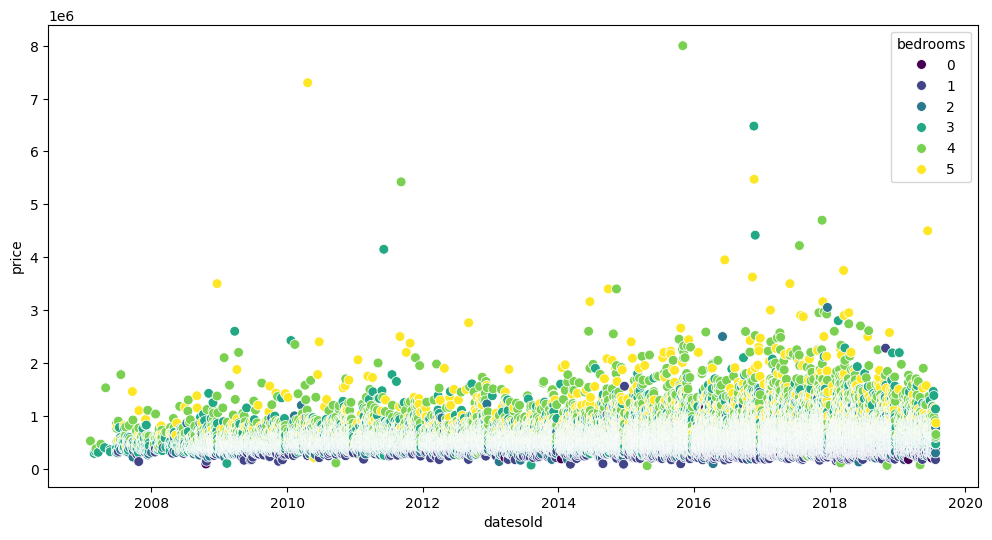

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'raw_sales_df' is your original DataFrame

# Convert 'datesold' to datetime format if not already
#raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])

# Create the scatter plot
plt.figure(figsize=(12, 6))

# Use seaborn's scatterplot, with 'price' on y-axis, 'datesold' on x-axis, and color by 'bedrooms'
sns.scatterplot(data=raw_sales_df, x='datesold', y='price', hue='bedrooms', palette='viridis', s=50)

# Connect the dots using lines for each property (assuming properties are identified by 'postcode')
for postcode in raw_sales_df['postcode'].unique():
    # Filter the data by postcode
    subset = raw_sales_df[raw_sales_df['postcode'] == postcode].sort_values(by='datesold')
    plt.plot(subset['datesold'], subset['price'], linestyle='-', marker='o', alpha=0.7)

# Customize plot labels and title
plt.title('House Price vs Date with Bedroom Type Color Coded', fontsize=16)
plt.xlabel('Date Sold', fontsize=14)
plt.ylabel('Price (in $)', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the legend for bedroom types
plt.legend(title='Bedrooms', loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


Final Preprocessed Dataset

After processing, the dataset should have:

Sequential features (X): Prepared for HMMs.
Hidden states (hidden_states): Used for training and validation.

In [16]:
# Save n_states and X
np.savez('hmm_data.npz', n_states=n_states, X=X)

print("Variables saved to hmm_data.npz")

Variables saved to hmm_data.npz


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Assuming raw_sales_df is your DataFrame and you're interested in the first few columns
# Drop any missing values
obs = raw_sales_df.dropna()

# Select the first four columns as observations (assuming they are relevant for HMM)
obs = obs[obs.columns[1:5]]  

# Set the number of observations to consider for each iteration (e.g., window size T)
T = 96

# Initialize empty lists to store the evaluation criteria results
AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different numbers of components (hidden states) for the HMM model
for n in range(2, 7):  # Number of states from 2 to 6
    a, b, c, d = [], [], [], []  # Lists to store values for each iteration
    
    first_time = True  # Flag to check if it's the first iteration

    # Iterate over the data with a sliding window of size T
    for i in range(0, len(obs) - T):  # Slide over the dataset
        # Define the HMM model
        if first_time:
            model = hmm.GaussianHMM(n_components=n, n_iter=100)
            first_time = False
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="c", n_iter=100)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(obs.iloc[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(obs.iloc[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1  # Number of free parameters in the model

        # Calculate evaluation criteria
        aic = -2 * log_likelihoods + 2 * k  # Akaike Information Criterion
        bic = -2 * log_likelihoods + k * np.log(4 * T)  # Bayesian Information Criterion
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))  # Hannan-Quinn Criterion
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)  # Consistent AIC

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

# Plot evaluation criteria for different numbers of components
plt.figure(figsize=(15, 10))

# Plot AIC values for different numbers of components
plt.subplot(2, 2, 1)
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")
plt.title("AIC for Different Numbers of States")
plt.legend()
plt.grid()

# Plot BIC values for different numbers of components
plt.subplot(2, 2, 2)
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.title("BIC for Different Numbers of States")
plt.legend()
plt.grid()

# Plot HQC values for different numbers of components
plt.subplot(2, 2, 3)
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.title("HQC for Different Numbers of States")
plt.legend()
plt.grid()

# Plot CAIC values for different numbers of components
plt.subplot(2, 2, 4)
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.title("CAIC for Different Numbers of States")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Model is not converging.  Current: -1382.6106630898246 is not greater than -1382.610659914709. Delta is -3.175115580233978e-06
Model is not converging.  Current: -1357.145890830768 is not greater than -1357.1458869574385. Delta is -3.87332943319052e-06
Model is not converging.  Current: -1360.3506143951759 is not greater than -1360.3506109780262. Delta is -3.4171496281487634e-06
Model is not converging.  Current: -1360.1490463589507 is not greater than -1360.1490432085493. Delta is -3.1504014259553514e-06
Model is not converging.  Current: -1360.3228776079343 is not greater than -1360.3228738190555. Delta is -3.7888787574047456e-06
Model is not converging.  Current: -1388.9492097268387 is not greater than -1388.949204753154. Delta is -4.973684781361953e-06
Model is not converging.  Current: -1359.117370343167 is not greater than -1359.1173679012156. Delta is -2.4419514375040308e-06
Model is not converging.  Current: -1359.3554814060824 is not greater than -1359.3554788420004. Delta is 

ValueError: startprob_ must sum to 1 (got nan)

Finding the Optimal Hidden States

In [ ]:


'''# Prepare your data (example with price data)
# Let's assume 'raw_sales_df' contains a 'price' column
# Here we're using a simple example of price as input data for HMM
# In reality, you may want to apply transformations or use more features

data = raw_sales_df['price'].values.reshape(-1, 1)  # Reshape for HMM

# Range of states to try
state_range = range(1, 11)  # Try from 1 to 10 hidden states

# Store BIC/AIC results
bic_values = []
aic_values = []

# Loop over different numbers of states and fit the HMM
for n_states in state_range:
    # Create an HMM with n_states
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
    
    # Fit the model
    model.fit(data)
    
    # Calculate BIC and AIC
    bic_values.append(model.bic(data))  # Bayesian Information Criterion
    aic_values.append(model.aic(data))  # Akaike Information Criterion

# Plot BIC and AIC for different numbers of hidden states
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(state_range, bic_values, marker='o', label='BIC')
plt.xlabel('Number of Hidden States')
plt.ylabel('BIC')
plt.title('BIC for Different Numbers of Hidden States')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(state_range, aic_values, marker='o', label='AIC')
plt.xlabel('Number of Hidden States')
plt.ylabel('AIC')
plt.title('AIC for Different Numbers of Hidden States')
plt.grid()

plt.tight_layout()
plt.show()

# Find the optimal number of states based on BIC or AIC (choose the minimum)
optimal_states_bic = state_range[np.argmin(bic_values)]
optimal_states_aic = state_range[np.argmin(aic_values)]

print(f"Optimal number of hidden states (based on BIC): {optimal_states_bic}")
print(f"Optimal number of hidden states (based on AIC): {optimal_states_aic}")'''


KeyboardInterrupt: 